In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)

In [6]:
dataset = pd.read_csv("/kaggle/input/mastercard-stock-history/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [7]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


In [8]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

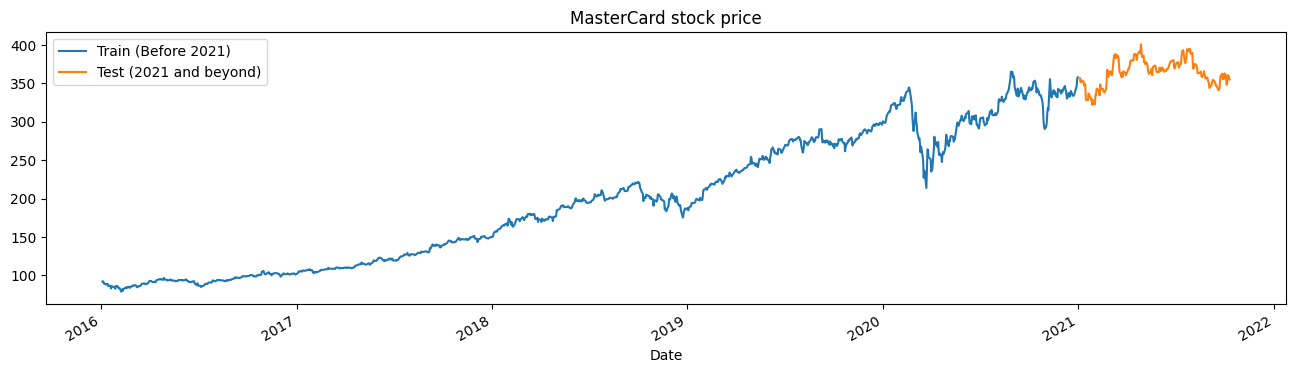

In [9]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [10]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [14]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 54ms/step - loss: 0.0174
Epoch 2/50
38/38 [==============================] - 2s 56ms/step - loss: 0.0028
Epoch 3/50
38/38 [==============================] - 2s 58ms/step - loss: 0.0023
Epoch 4/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0014
Epoch 6/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0015
Epoch 7/50
38/38 [==============================] - 2s 53ms/step - loss: 9.3258e-04
Epoch 8/50
38/38 [==============================] - 2s 53ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 2s 52ms/step - loss: 9.6754e-04
Epoch 10/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0010
Epoch 11/50
38/38 [==============================] - 2s 54ms/step - loss: 8.1107e-04
Epoch 12/50
38/38 [==============================] - 2s 53ms/step - loss: 8.1233e-04
Epoch 13/50
38/38 [==

In [17]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)

inputs = sc.transform(inputs)

X_test, y_test = split_sequence(inputs, n_steps)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
predicted_stock_price = model_lstm.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 1s 22ms/step


In [19]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

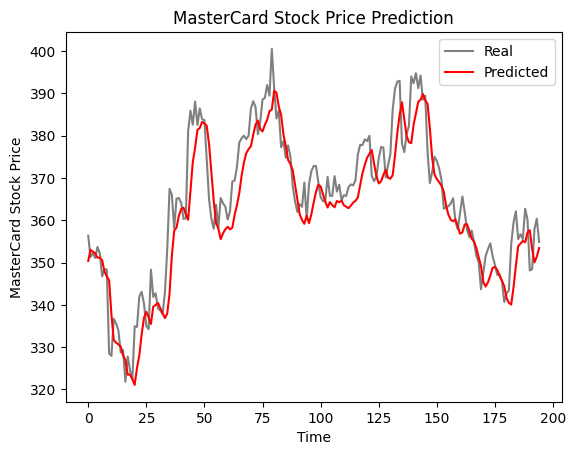

In [20]:
plot_predictions(test_set,predicted_stock_price)

In [21]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 7.05.


In [22]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 4s 45ms/step - loss: 0.0084
Epoch 2/50
38/38 [==============================] - 2s 44ms/step - loss: 0.0015
Epoch 3/50
38/38 [==============================] - 2s 51ms/step - loss: 0.0012
Epoch 4/50
38/38 [==============================] - 2s 46ms/step - loss: 0.0011
Epoch 5/50
38/38 [==============================] - 2s 44ms/step - loss: 8.5433e-04
Epoch 6/50
38/38 [==============================] - 2s 45ms/step - loss: 0.0010
Epoch 7/50
38/38 [==============================] - 2s 44ms/step - loss: 6.0043e-04
Epoch 8/50
38/38 [==============================] - 2s 45ms/step - loss: 7.8010e-04
Epoch 9/50
38/38 [==============================] - 2s 44ms/step - loss: 6.5793e-04
Epoch 10/50
38/38 [==============================] - 2s 46ms/step - loss: 7.4954e-04
Epoch 11/50
38/38 [==============================] - 2s 45ms/step - loss: 6.1927e-04
Epoch 12/50
38/38 [==============================] - 2s 44ms/step - loss: 5.8301e-04
Epoch 13/

7/7 [==============================] - 1s 13ms/step


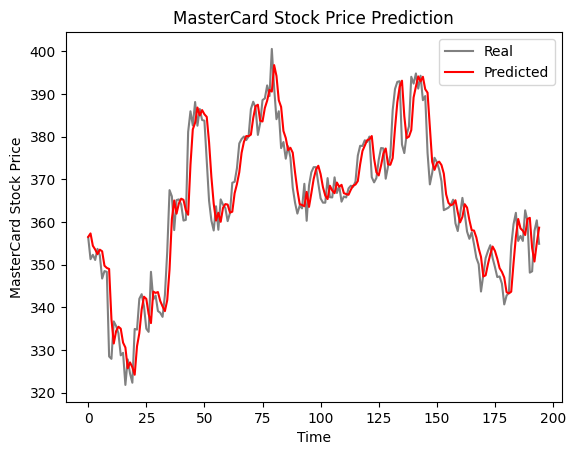

In [24]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [25]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.76.
